In [1]:
import sys 
sys.path.append('/Users/patroklos/Desktop/delphi_')

import torch as ch
from torch import Tensor
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.kl import kl_divergence
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm 
import IPython 

from delphi.distributions.unknown_truncation_multivariate_normal import TruncatedMultivariateNormal
from delphi import oracle
from delphi.utils import constants as consts
from delphi.utils.helpers import setup_store_with_metadata
from delphi.utils.helpers import cov
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader

In [2]:
args = Parameters({ 
    'samples': 500, 
    'batch_size': 10, 
    'tol': 1e-1, 
    'lr': 1e-1, 
    'out_dir': '/Users/patroklos/Desktop/exp/multi_truncated',
    'exp': 'again', 
    'trials': 20,
    'var': 10,
    'dims': 2,
    'd': 100,
    'iter_': 5,
    'table_name': 'logs',
})

Synthetic Data Experiment for 2 Dimensional Censored Gaussian Distributions 

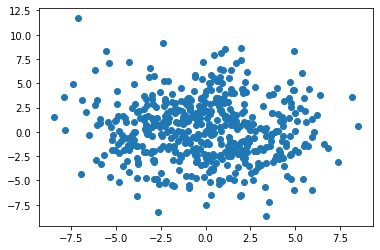

In [3]:
M = MultivariateNormal(ch.zeros(args.dims), 10*ch.eye(args.dims))
samples = M.sample([args.samples])

plt.scatter(samples[:,0], samples[:,1])
plt.show()

Truncate the Dataset

alpha: 0.5
empirical loc: 
 tensor([-2.6451,  0.3235])
empirical covariance matrix: 
 tensor([[ 3.4656, -0.1869],
        [-0.1869,  9.3239]])


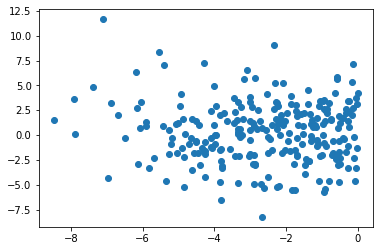

In [4]:
phi = oracle.Right(Tensor([0.0, float('inf')]))
indices = phi(samples).nonzero(as_tuple=False)[:,0]
S = samples[indices]
alpha = S.size(0) / samples.size(0)
print("alpha: {}".format(alpha))
emp_loc = S.mean(0)
print("empirical loc: \n", emp_loc)
emp_covariance_matrix = cov(S)
print("empirical covariance matrix: \n", emp_covariance_matrix)

plt.scatter(S[:,0], S[:,1])
plt.show()

Run algorithm to Remove Bias from the Dataset

In [5]:
truncated = TruncatedMultivariateNormal(alpha=alpha, 
                                        iter_=args.iter_,
                                        step_lr=100,
                                        val=50, 
                                        bs=10)
# import pdb; pdb.set_trace()
truncated.fit(S)

print("estimated loc: ", truncated.loc)
print("estimated covariance matrix: ", truncated.covariance_matrix)

loc grad:  tensor([-0.4016, -0.3280])
covariance_matrix grad:  tensor([[-0.3125,  0.0499],
        [ 0.0499,  0.4261]])
loc grad:  tensor([ 0.8719, -1.5240])
covariance_matrix grad:  tensor([[ 0.6929, -1.7092],
        [-1.7092,  2.5375]])
loc grad:  tensor([-0.9438, -0.0123])
covariance_matrix grad:  tensor([[-0.2445, -0.0226],
        [-0.0226, -0.5583]])
loc grad:  tensor([-0.5663,  0.8943])
covariance_matrix grad:  tensor([[-0.0356, -0.4240],
        [-0.4240,  0.1640]])
loc grad:  tensor([-0.3639, -0.1492])
covariance_matrix grad:  tensor([[-0.2408,  0.4152],
        [ 0.4152,  0.0720]])
loc grad:  tensor([-1.6709,  0.0489])
covariance_matrix grad:  tensor([[ 0.0183,  0.0926],
        [ 0.0926, -0.5355]])
loc grad:  tensor([-0.5751,  0.2362])
covariance_matrix grad:  tensor([[-0.0616, -0.0541],
        [-0.0541, -0.3110]])
loc grad:  tensor([-1.3272,  0.3965])
covariance_matrix grad:  tensor([[-0.0953, -0.2104],
        [-0.2104, -0.3657]])
loc grad:  tensor([-2.3316, -1.0504])
co

loc grad:  tensor([-0.7467,  0.1555])
covariance_matrix grad:  tensor([[-0.1041, -0.1763],
        [-0.1763, -0.2238]])
loc grad:  tensor([-1.4137,  0.3312])
covariance_matrix grad:  tensor([[ 0.1060, -0.2325],
        [-0.2325,  0.0107]])
loc grad:  tensor([-1.4718, -0.9380])
covariance_matrix grad:  tensor([[ 0.1057,  0.5980],
        [ 0.5980, -0.1260]])
loc grad:  tensor([-1.2248,  0.4888])
covariance_matrix grad:  tensor([[-0.0654, -0.1792],
        [-0.1792, -0.3449]])
loc grad:  tensor([ 0.5445, -1.9824])
covariance_matrix grad:  tensor([[ 0.8781, -1.8766],
        [-1.8766,  2.6655]])
loc grad:  tensor([-2.4010,  0.9426])
covariance_matrix grad:  tensor([[ 0.0432, -0.2731],
        [-0.2731,  0.1796]])
loc grad:  tensor([-0.5281, -0.0335])
covariance_matrix grad:  tensor([[-0.4965,  0.0706],
        [ 0.0706, -0.6137]])
loc grad:  tensor([-1.3443,  0.9714])
covariance_matrix grad:  tensor([[ 0.2617, -0.2106],
        [-0.2106,  0.1085]])
loc grad:  tensor([-1.1041,  0.2939])
co

In [16]:
store = Store(args.out_dir + '/' + args.exp)

schema = { 
    'kl_div_emp': float, 
    'kl_div_truncated': float,
    'var': int,
    'alpha': float,
}

# right truncate at 0
phi = oracle.Right(Tensor([0.0, float('inf')]))


store.add_table(args.table_name, schema)

for i in range(args.trials): 
    for var in range(1, args.var + 1):
        # create new dataset
        gt_loc, gt_scale = ch.zeros(args.dims), var * ch.eye(args.dims)
        gt_dist = MultivariateNormal(gt_loc, gt_scale)
        samples = gt_dist.sample([args.samples])

        # truncate
        indices = phi(samples).nonzero()[:,0]
        S = samples[indices]
        alpha = S.size(0) / samples.size(0)
        
        emp_loc = S.mean(0)
        emp_cov = cov(S)
        emp_scale = Tensor(sqrtm(emp_cov.numpy()))

        emp_dist = MultivariateNormal(emp_loc, emp_cov)
        
        S_norm = (S - emp_dist.loc) @ emp_scale.inverse()

        truncated = TruncatedMultivariateNormal(alpha=alpha, 
                                                iter_=2,
                                                bs=10,
                                                lr=1e-1)
        truncated.fit(S_norm)


        loc_ = truncated.loc @ emp_scale + emp_loc
        scale_ = truncated.covariance_matrix @ emp_cov

        trunc_dist = MultivariateNormal(loc_, scale_)

        kl_trunc = float(kl_divergence(gt_dist, trunc_dist))
        kl_emp = float(kl_divergence(gt_dist, emp_dist))


        store[args.table_name].update_row({ 
            'kl_div_emp': kl_emp, 
            'kl_div_truncated': kl_trunc,
            'var': var,
            'alpha': alpha,
        })
        store[args.table_name].flush_row()
    
store.close()

Logging in: /Users/patroklos/Desktop/exp/multi_truncated/sanity_check/a78b4ea6-b14e-4500-9608-1252114335a5
loc grad:  tensor([-0.2636,  0.0134])
covariance_matrix grad:  tensor([[-0.3536,  0.0060],
        [ 0.0060, -0.0085]])
loc grad:  tensor([-0.2266, -0.1681])
covariance_matrix grad:  tensor([[-0.0825,  0.1416],
        [ 0.1416, -0.2362]])
loc grad:  tensor([-0.1132,  0.0075])
covariance_matrix grad:  tensor([[-0.0825, -0.0717],
        [-0.0717,  0.0423]])
loc grad:  tensor([-0.0216, -0.1352])
covariance_matrix grad:  tensor([[-0.0246, -0.0646],
        [-0.0646, -0.0097]])
loc grad:  tensor([0.0149, 0.0998])
covariance_matrix grad:  tensor([[-0.1690, -0.1458],
        [-0.1458, -0.1913]])
loc grad:  tensor([-0.0823, -0.4853])
covariance_matrix grad:  tensor([[-0.1238,  0.1262],
        [ 0.1262,  0.1904]])
loc grad:  tensor([-0.3202,  0.0629])
covariance_matrix grad:  tensor([[-0.1726,  0.0548],
        [ 0.0548,  0.0129]])
loc grad:  tensor([0.5270, 0.2582])
covariance_matrix g

loc grad:  tensor([6.7829, 3.1424])
covariance_matrix grad:  tensor([[13.3059,  5.0659],
        [ 5.0659,  0.9285]])
loc grad:  tensor([-0.2856, -0.8316])
covariance_matrix grad:  tensor([[-0.6514,  0.1597],
        [ 0.1597, -0.3664]])
loc grad:  tensor([-1.2633,  1.4344])
covariance_matrix grad:  tensor([[-0.0070, -0.6750],
        [-0.6750,  0.5910]])
loc grad:  tensor([ 0.0162, -0.3648])
covariance_matrix grad:  tensor([[-0.5073,  0.2337],
        [ 0.2337,  0.3085]])
loc grad:  tensor([-0.7388, -1.4722])
covariance_matrix grad:  tensor([[-0.3393,  0.1486],
        [ 0.1486,  0.5206]])
loc grad:  tensor([-1.0517,  0.7899])
covariance_matrix grad:  tensor([[-0.5163, -0.4794],
        [-0.4794, -0.1754]])
loc grad:  tensor([ 0.3049, -0.8611])
covariance_matrix grad:  tensor([[-0.5193, -0.3897],
        [-0.3897,  0.3035]])
loc grad:  tensor([ 0.1838, -0.7305])
covariance_matrix grad:  tensor([[-0.5820, -0.0954],
        [-0.0954, -0.1901]])
loc grad:  tensor([-0.4201, -0.5774])
cova

loc grad:  tensor([-0.2601,  0.4629])
covariance_matrix grad:  tensor([[-0.3586, -0.0165],
        [-0.0165,  0.1373]])
loc grad:  tensor([-0.2457, -0.0180])
covariance_matrix grad:  tensor([[-0.0199,  0.0907],
        [ 0.0907,  0.5170]])
loc grad:  tensor([0.1164, 0.3054])
covariance_matrix grad:  tensor([[-0.0203,  0.1154],
        [ 0.1154, -0.1069]])
loc grad:  tensor([-0.3939,  0.0094])
covariance_matrix grad:  tensor([[-0.2095,  0.0422],
        [ 0.0422,  0.0268]])
loc grad:  tensor([-0.3400, -0.2533])
covariance_matrix grad:  tensor([[-0.2057, -0.0893],
        [-0.0893, -0.0545]])
loc grad:  tensor([12.2132, -3.2091])
covariance_matrix grad:  tensor([[22.1648, -5.3472],
        [-5.3472, -0.1289]])
loc grad:  tensor([0.5078, 4.7499])
covariance_matrix grad:  tensor([[-1.5817,  0.7882],
        [ 0.7882,  1.8500]])
loc grad:  tensor([-3.2830, -4.3066])
covariance_matrix grad:  tensor([[-2.3714,  1.0804],
        [ 1.0804, -1.2823]])
cov: tensor([[-1.0988,  0.3753],
        [ 0

loc grad:  tensor([ 0.2864, -0.4461])
covariance_matrix grad:  tensor([[-0.1212, -0.0440],
        [-0.0440,  0.0963]])
loc grad:  tensor([0.4017, 0.0301])
covariance_matrix grad:  tensor([[ 0.3015, -0.1336],
        [-0.1336, -0.1374]])
loc grad:  tensor([-0.3639,  0.2153])
covariance_matrix grad:  tensor([[-0.1454, -0.0804],
        [-0.0804, -0.0655]])
loc grad:  tensor([0.6828, 0.0919])
covariance_matrix grad:  tensor([[ 0.2859,  0.0055],
        [ 0.0055, -0.0438]])
loc grad:  tensor([-0.7267,  0.0539])
covariance_matrix grad:  tensor([[-0.1340, -0.1632],
        [-0.1632, -0.0811]])
loc grad:  tensor([ 0.9129, -0.0811])
covariance_matrix grad:  tensor([[ 0.8480, -0.2075],
        [-0.2075, -0.1368]])
loc grad:  tensor([-0.4729,  0.1547])
covariance_matrix grad:  tensor([[-0.3224, -0.0278],
        [-0.0278, -0.1138]])
loc grad:  tensor([-0.2160, -0.0516])
covariance_matrix grad:  tensor([[ 0.0214, -0.0222],
        [-0.0222, -0.1563]])
loc grad:  tensor([0.0058, 0.6262])
covarian

loc grad:  tensor([0.0745, 0.4636])
covariance_matrix grad:  tensor([[-0.2886, -0.0566],
        [-0.0566,  0.2602]])
loc grad:  tensor([-0.5124, -0.3768])
covariance_matrix grad:  tensor([[-0.2525, -0.0084],
        [-0.0084, -0.3632]])
loc grad:  tensor([-0.1572, -0.2524])
covariance_matrix grad:  tensor([[-0.2308,  0.1166],
        [ 0.1166,  0.2437]])
loc grad:  tensor([-0.5728, -0.0305])
covariance_matrix grad:  tensor([[-0.2456,  0.0027],
        [ 0.0027,  0.0022]])
loc grad:  tensor([0.0926, 0.2457])
covariance_matrix grad:  tensor([[-0.1374,  0.1234],
        [ 0.1234, -0.2571]])
loc grad:  tensor([-0.0019, -0.4120])
covariance_matrix grad:  tensor([[-0.0470, -0.0035],
        [-0.0035, -0.1337]])
loc grad:  tensor([ 0.4318, -0.2750])
covariance_matrix grad:  tensor([[ 0.9863, -0.5093],
        [-0.5093, -0.1619]])
loc grad:  tensor([-0.0342, -0.1483])
covariance_matrix grad:  tensor([[-0.0297,  0.0232],
        [ 0.0232,  0.2922]])
loc grad:  tensor([1.6758, 0.3393])
covarian

loc grad:  tensor([-0.6546, -0.5205])
covariance_matrix grad:  tensor([[-0.1966,  0.3933],
        [ 0.3933, -0.0320]])
loc grad:  tensor([-0.0959,  0.2603])
covariance_matrix grad:  tensor([[-0.1233, -0.0687],
        [-0.0687, -0.3175]])
loc grad:  tensor([0.4659, 0.0308])
covariance_matrix grad:  tensor([[-0.0731,  0.0517],
        [ 0.0517, -0.3083]])
loc grad:  tensor([0.0866, 0.0762])
covariance_matrix grad:  tensor([[-0.0792,  0.0414],
        [ 0.0414,  0.0195]])
loc grad:  tensor([-0.7585, -0.4036])
covariance_matrix grad:  tensor([[-0.0494,  0.1398],
        [ 0.1398, -0.0799]])
loc grad:  tensor([-0.1912, -0.1920])
covariance_matrix grad:  tensor([[ 0.0624,  0.0918],
        [ 0.0918, -0.0402]])
loc grad:  tensor([ 0.4066, -0.7803])
covariance_matrix grad:  tensor([[ 0.0527, -0.3278],
        [-0.3278,  0.2336]])
loc grad:  tensor([-0.8251,  0.2645])
covariance_matrix grad:  tensor([[-0.2037, -0.1023],
        [-0.1023, -0.0454]])
loc grad:  tensor([0.6710, 0.3740])
covarian

loc grad:  tensor([0.0448, 0.2122])
covariance_matrix grad:  tensor([[-0.0224,  0.0438],
        [ 0.0438, -0.2301]])
loc grad:  tensor([ 0.0499, -1.2180])
covariance_matrix grad:  tensor([[-0.2645, -0.1807],
        [-0.1807,  1.0843]])
loc grad:  tensor([ 0.3703, -0.6052])
covariance_matrix grad:  tensor([[ 0.3814, -0.1358],
        [-0.1358,  0.0278]])
loc grad:  tensor([5.0860, 0.0078])
covariance_matrix grad:  tensor([[ 9.2554, -1.1515],
        [-1.1515, -0.4363]])
loc grad:  tensor([-0.3872, -0.3402])
covariance_matrix grad:  tensor([[-0.6580,  0.3969],
        [ 0.3969, -0.0098]])
loc grad:  tensor([-0.4670,  0.0223])
covariance_matrix grad:  tensor([[-0.4789,  0.1769],
        [ 0.1769, -0.3277]])
loc grad:  tensor([-0.9072, -0.1881])
covariance_matrix grad:  tensor([[-0.2532,  0.5508],
        [ 0.5508,  0.4896]])
loc grad:  tensor([-0.3960, -0.1696])
covariance_matrix grad:  tensor([[-0.3666,  0.1249],
        [ 0.1249, -0.2848]])
loc grad:  tensor([-0.7560,  0.0459])
covari

loc grad:  tensor([0.2188, 0.0526])
covariance_matrix grad:  tensor([[ 0.5905, -0.0755],
        [-0.0755, -0.2584]])
loc grad:  tensor([0.2273, 0.7644])
covariance_matrix grad:  tensor([[0.1207, 0.0946],
        [0.0946, 0.6061]])
loc grad:  tensor([ 4.0047, -1.2469])
covariance_matrix grad:  tensor([[ 7.6855, -2.3225],
        [-2.3225,  0.1390]])
loc grad:  tensor([-1.0856, -1.0043])
covariance_matrix grad:  tensor([[-0.5278,  0.3028],
        [ 0.3028,  0.1364]])
loc grad:  tensor([-0.9058,  0.9292])
covariance_matrix grad:  tensor([[-0.3443, -0.4783],
        [-0.4783,  0.6754]])
loc grad:  tensor([ 0.0083, -0.4278])
covariance_matrix grad:  tensor([[-0.4447,  0.0408],
        [ 0.0408, -0.3086]])
loc grad:  tensor([-0.4550,  0.3298])
covariance_matrix grad:  tensor([[-0.2956,  0.0587],
        [ 0.0587, -0.0715]])
loc grad:  tensor([-0.6245, -0.9961])
covariance_matrix grad:  tensor([[-0.2804,  0.2984],
        [ 0.2984, -0.0029]])
loc grad:  tensor([-0.6950,  0.4243])
covariance

loc grad:  tensor([-0.0034, -0.1049])
covariance_matrix grad:  tensor([[-0.1839,  0.0910],
        [ 0.0910, -0.0868]])
loc grad:  tensor([0.0502, 0.5954])
covariance_matrix grad:  tensor([[-0.2628,  0.0931],
        [ 0.0931, -0.0654]])
loc grad:  tensor([-0.1700, -0.3239])
covariance_matrix grad:  tensor([[-0.1136,  0.2808],
        [ 0.2808,  0.0841]])
loc grad:  tensor([ 0.3595, -0.3965])
covariance_matrix grad:  tensor([[ 0.1064, -0.1166],
        [-0.1166, -0.2568]])
loc grad:  tensor([-0.4625,  0.9772])
covariance_matrix grad:  tensor([[ 0.0024, -0.5338],
        [-0.5338,  0.9464]])
loc grad:  tensor([0.0499, 0.2438])
covariance_matrix grad:  tensor([[-0.0317,  0.0482],
        [ 0.0482, -0.2655]])
loc grad:  tensor([-0.6777,  0.1571])
covariance_matrix grad:  tensor([[-0.1975,  0.0134],
        [ 0.0134, -0.0684]])
loc grad:  tensor([ 0.2147, -0.2493])
covariance_matrix grad:  tensor([[ 0.4423, -0.2303],
        [-0.2303,  0.0952]])
loc grad:  tensor([ 0.2966, -0.5603])
covari

loc grad:  tensor([-0.3697, -1.0992])
covariance_matrix grad:  tensor([[-0.2402,  0.1975],
        [ 0.1975,  0.1865]])
loc grad:  tensor([-0.5261, -0.3277])
covariance_matrix grad:  tensor([[-0.4013,  0.2239],
        [ 0.2239, -0.3183]])
loc grad:  tensor([-0.5850,  0.4591])
covariance_matrix grad:  tensor([[-0.2029, -0.1733],
        [-0.1733,  0.3755]])
loc grad:  tensor([0.7003, 0.3770])
covariance_matrix grad:  tensor([[-0.1846, -0.0342],
        [-0.0342, -0.1450]])
loc grad:  tensor([-0.0774, -0.5434])
covariance_matrix grad:  tensor([[-0.4265,  0.2554],
        [ 0.2554, -0.0349]])
loc grad:  tensor([ 0.4091, -0.1593])
covariance_matrix grad:  tensor([[ 0.0202,  0.0582],
        [ 0.0582, -0.3271]])
loc grad:  tensor([-0.1697,  0.4193])
covariance_matrix grad:  tensor([[-0.0012,  0.0953],
        [ 0.0953,  0.3172]])
loc grad:  tensor([0.3169, 0.0461])
covariance_matrix grad:  tensor([[-0.1287,  0.0124],
        [ 0.0124, -0.0042]])
loc grad:  tensor([-0.2127, -0.0920])
covari

loc grad:  tensor([ 0.0582, -0.3586])
covariance_matrix grad:  tensor([[-0.1591,  0.0619],
        [ 0.0619,  0.2299]])
cov: tensor([[3.0344, 0.3459],
        [0.3459, 1.1481]], grad_fn=<InverseBackward0>)
mu: tensor([0.3938, 0.0862], grad_fn=<SqueezeBackward3>)
Iteration 2 | Log Likelihood: 0.886
loc grad:  tensor([-0.1603,  0.1210])
covariance_matrix grad:  tensor([[-0.0377,  0.2490],
        [ 0.2490, -0.1583]])
loc grad:  tensor([-0.3833,  0.4347])
covariance_matrix grad:  tensor([[-0.0832, -0.0799],
        [-0.0799, -0.0520]])
loc grad:  tensor([-0.2870, -0.1121])
covariance_matrix grad:  tensor([[-0.1719,  0.2811],
        [ 0.2811,  0.1382]])
loc grad:  tensor([-0.1471,  0.4036])
covariance_matrix grad:  tensor([[-0.1971, -0.0427],
        [-0.0427,  0.0808]])
loc grad:  tensor([-0.2129,  0.1592])
covariance_matrix grad:  tensor([[-0.2737,  0.0330],
        [ 0.0330, -0.1593]])
loc grad:  tensor([ 0.5105, -0.0623])
covariance_matrix grad:  tensor([[-0.1818, -0.1574],
        [-

loc grad:  tensor([-0.2552, -0.0147])
covariance_matrix grad:  tensor([[-0.2178,  0.1239],
        [ 0.1239,  0.2282]])
loc grad:  tensor([0.3074, 0.2889])
covariance_matrix grad:  tensor([[-0.0676,  0.0933],
        [ 0.0933,  0.2566]])
loc grad:  tensor([0.0508, 0.2006])
covariance_matrix grad:  tensor([[ 0.0612,  0.1475],
        [ 0.1475, -0.1466]])
loc grad:  tensor([-0.0401, -0.7169])
covariance_matrix grad:  tensor([[-0.3228,  0.1841],
        [ 0.1841,  0.2481]])
loc grad:  tensor([-0.2796,  0.1419])
covariance_matrix grad:  tensor([[-0.2320,  0.0263],
        [ 0.0263, -0.2638]])
loc grad:  tensor([ 2.4864, -0.0151])
covariance_matrix grad:  tensor([[ 4.6351, -0.9554],
        [-0.9554, -0.2380]])
loc grad:  tensor([-0.2284,  0.0087])
covariance_matrix grad:  tensor([[-0.1896, -0.0580],
        [-0.0580, -0.3500]])
loc grad:  tensor([-0.5623, -0.3965])
covariance_matrix grad:  tensor([[-0.5031,  0.2167],
        [ 0.2167,  0.1146]])
loc grad:  tensor([0.1128, 0.7164])
covarian

covariance_matrix grad:  tensor([[-0.2840, -0.1479],
        [-0.1479, -0.1876]])
loc grad:  tensor([-0.8789, -0.4720])
covariance_matrix grad:  tensor([[-0.0355,  0.0174],
        [ 0.0174, -0.0385]])
loc grad:  tensor([-0.4207, -0.1595])
covariance_matrix grad:  tensor([[-0.1914,  0.1128],
        [ 0.1128, -0.3471]])
loc grad:  tensor([-0.4142, -0.1488])
covariance_matrix grad:  tensor([[-0.1916, -0.0202],
        [-0.0202, -0.1921]])
loc grad:  tensor([-0.2556, -0.5960])
covariance_matrix grad:  tensor([[-0.2377,  0.1049],
        [ 0.1049, -0.3113]])
loc grad:  tensor([-0.7813,  0.2028])
covariance_matrix grad:  tensor([[-0.1621, -0.2669],
        [-0.2669,  0.8913]])
loc grad:  tensor([-0.1529, -0.6708])
covariance_matrix grad:  tensor([[-0.2006, -0.0363],
        [-0.0363, -0.0365]])
loc grad:  tensor([ 0.3606, -0.6500])
covariance_matrix grad:  tensor([[ 0.3718, -1.1004],
        [-1.1004,  1.5091]])
loc grad:  tensor([-0.2434,  0.4982])
covariance_matrix grad:  tensor([[-5.102

loc grad:  tensor([-0.6328,  0.1408])
covariance_matrix grad:  tensor([[-0.0783, -0.1706],
        [-0.1706, -0.4092]])
cov: tensor([[ 1.0000, -0.0266],
        [-0.0266,  0.9829]], grad_fn=<InverseBackward0>)
mu: tensor([-0.0035, -0.0161], grad_fn=<SqueezeBackward3>)
Iteration 1 | Log Likelihood: 1.029
loc grad:  tensor([ 0.4096, -0.1372])
covariance_matrix grad:  tensor([[ 0.4851,  0.0417],
        [ 0.0417, -0.2095]])
loc grad:  tensor([ 0.0825, -0.2975])
covariance_matrix grad:  tensor([[-0.0705,  0.1193],
        [ 0.1193, -0.1738]])
loc grad:  tensor([-0.0846, -0.4810])
covariance_matrix grad:  tensor([[-0.3508,  0.1091],
        [ 0.1091, -0.1978]])
loc grad:  tensor([-0.2781,  0.0448])
covariance_matrix grad:  tensor([[-0.1387,  0.0126],
        [ 0.0126,  0.3222]])
loc grad:  tensor([-0.1812,  0.2389])
covariance_matrix grad:  tensor([[-0.1512, -0.2271],
        [-0.2271,  0.1133]])
loc grad:  tensor([0.2012, 0.0912])
covariance_matrix grad:  tensor([[ 0.3351, -0.2328],
      

loc grad:  tensor([-0.6850, -0.3025])
covariance_matrix grad:  tensor([[-0.0927,  0.0628],
        [ 0.0628, -0.1581]])
loc grad:  tensor([0.2884, 0.3508])
covariance_matrix grad:  tensor([[-0.2148,  0.1180],
        [ 0.1180, -0.2745]])
loc grad:  tensor([0.4514, 0.1735])
covariance_matrix grad:  tensor([[-0.1607,  0.0728],
        [ 0.0728, -0.0876]])
loc grad:  tensor([0.1205, 0.1426])
covariance_matrix grad:  tensor([[ 0.4079, -0.4513],
        [-0.4513, -0.2206]])
loc grad:  tensor([ 0.5316, -0.9007])
covariance_matrix grad:  tensor([[ 0.1134, -0.3438],
        [-0.3438,  1.1615]])
loc grad:  tensor([-0.0200, -0.6873])
covariance_matrix grad:  tensor([[ 0.0400,  0.0564],
        [ 0.0564, -0.4821]])
loc grad:  tensor([ 0.0187, -0.0515])
covariance_matrix grad:  tensor([[-0.1780,  0.0265],
        [ 0.0265,  0.0082]])
loc grad:  tensor([ 0.3426, -0.1776])
covariance_matrix grad:  tensor([[-0.2307, -0.1822],
        [-0.1822,  0.2762]])
loc grad:  tensor([-1.0915,  1.1514])
covarian

loc grad:  tensor([-0.6293,  0.8275])
covariance_matrix grad:  tensor([[-0.8074, -0.3049],
        [-0.3049, -0.3405]])
loc grad:  tensor([-0.9309,  2.3409])
covariance_matrix grad:  tensor([[-0.4813, -0.3956],
        [-0.3956,  0.4363]])
loc grad:  tensor([-2.0773, -0.2139])
covariance_matrix grad:  tensor([[-0.0621,  0.0383],
        [ 0.0383, -0.9486]])
cov: tensor([[5.3684, 0.1819],
        [0.1819, 1.1313]], grad_fn=<InverseBackward0>)
mu: tensor([ 0.3651, -0.0964], grad_fn=<SqueezeBackward3>)
Iteration 2 | Log Likelihood: 1.936
loc grad:  tensor([-0.1732,  0.3384])
covariance_matrix grad:  tensor([[-0.1652,  0.0106],
        [ 0.0106, -0.2561]])
loc grad:  tensor([-0.2250, -0.3152])
covariance_matrix grad:  tensor([[-0.2497, -0.0561],
        [-0.0561, -0.2509]])
loc grad:  tensor([ 3.7999, -1.2069])
covariance_matrix grad:  tensor([[ 5.5903, -1.1337],
        [-1.1337, -0.0885]])
loc grad:  tensor([0.2614, 0.7284])
covariance_matrix grad:  tensor([[-0.3946,  0.2127],
        [ 

loc grad:  tensor([ 0.2758, -0.0989])
covariance_matrix grad:  tensor([[ 0.2810, -0.1671],
        [-0.1671, -0.1814]])
loc grad:  tensor([-1.0133, -0.2619])
covariance_matrix grad:  tensor([[ 0.2197, -0.1363],
        [-0.1363,  0.4991]])
loc grad:  tensor([-0.4415,  0.1299])
covariance_matrix grad:  tensor([[-0.0467, -0.0237],
        [-0.0237, -0.1400]])
loc grad:  tensor([-0.6192, -0.2237])
covariance_matrix grad:  tensor([[ 0.0199, -0.0626],
        [-0.0626,  0.3478]])
loc grad:  tensor([-0.6772, -0.2622])
covariance_matrix grad:  tensor([[-0.2386,  0.0252],
        [ 0.0252, -0.3670]])
loc grad:  tensor([0.2295, 0.0204])
covariance_matrix grad:  tensor([[ 0.2655,  0.1032],
        [ 0.1032, -0.4024]])
loc grad:  tensor([-0.3169,  0.1435])
covariance_matrix grad:  tensor([[-0.0740,  0.1723],
        [ 0.1723, -0.0111]])
loc grad:  tensor([ 0.1942, -0.5010])
covariance_matrix grad:  tensor([[-0.4193, -0.1966],
        [-0.1966, -0.0196]])
loc grad:  tensor([0.1736, 0.6107])
covari

loc grad:  tensor([-0.4677,  1.2002])
covariance_matrix grad:  tensor([[-0.0535, -0.4139],
        [-0.4139,  0.3977]])
cov: tensor([[ 1.1657, -0.0337],
        [-0.0337,  1.0445]], grad_fn=<InverseBackward0>)
mu: tensor([-0.0739, -0.0209], grad_fn=<SqueezeBackward3>)
Iteration 1 | Log Likelihood: 1.138
loc grad:  tensor([0.0768, 0.2033])
covariance_matrix grad:  tensor([[-0.1620, -0.1463],
        [-0.1463,  0.1274]])
loc grad:  tensor([ 0.1336, -0.0768])
covariance_matrix grad:  tensor([[0.0548, 0.1268],
        [0.1268, 0.0798]])
loc grad:  tensor([-0.1672,  0.3511])
covariance_matrix grad:  tensor([[-0.0005, -0.0550],
        [-0.0550, -0.2518]])
loc grad:  tensor([-0.5395,  0.3387])
covariance_matrix grad:  tensor([[-0.2163, -0.1279],
        [-0.1279, -0.1984]])
loc grad:  tensor([ 0.4102, -0.2523])
covariance_matrix grad:  tensor([[ 0.0988, -0.2030],
        [-0.2030,  0.0060]])
loc grad:  tensor([-0.5311, -0.5728])
covariance_matrix grad:  tensor([[-0.0642,  0.4055],
        [ 

loc grad:  tensor([0.1463, 0.1462])
covariance_matrix grad:  tensor([[-0.3025,  0.1157],
        [ 0.1157, -0.1531]])
loc grad:  tensor([-1.0714, -0.1984])
covariance_matrix grad:  tensor([[-0.0452,  0.1759],
        [ 0.1759, -0.1060]])
loc grad:  tensor([-0.3557,  0.2116])
covariance_matrix grad:  tensor([[ 0.0907,  0.0693],
        [ 0.0693, -0.2651]])
loc grad:  tensor([ 0.0453, -0.8187])
covariance_matrix grad:  tensor([[0.1101, 0.1302],
        [0.1302, 0.1961]])
loc grad:  tensor([-0.2952,  1.1495])
covariance_matrix grad:  tensor([[-0.0906, -0.2063],
        [-0.2063,  0.2343]])
loc grad:  tensor([-0.1940, -0.0245])
covariance_matrix grad:  tensor([[-0.3560,  0.0683],
        [ 0.0683, -0.2658]])
loc grad:  tensor([-0.1384,  0.0748])
covariance_matrix grad:  tensor([[-0.3599,  0.0300],
        [ 0.0300, -0.0662]])
loc grad:  tensor([ 0.2977, -0.0207])
covariance_matrix grad:  tensor([[-0.2415, -0.0594],
        [-0.0594, -0.4591]])
loc grad:  tensor([ 1.9938, -0.2476])
covarian

covariance_matrix grad:  tensor([[ 0.0265, -0.2248],
        [-0.2248,  0.2535]])
cov: tensor([[1.2322, 0.0286],
        [0.0286, 1.0639]], grad_fn=<InverseBackward0>)
mu: tensor([-0.1231,  0.0553], grad_fn=<SqueezeBackward3>)
Iteration 2 | Log Likelihood: 1.164
loc grad:  tensor([ 0.4935, -0.3379])
covariance_matrix grad:  tensor([[ 0.3372, -0.0912],
        [-0.0912, -0.1708]])
loc grad:  tensor([-0.5291, -0.1395])
covariance_matrix grad:  tensor([[-0.1036, -0.1117],
        [-0.1117,  0.3393]])
loc grad:  tensor([0.4035, 0.2502])
covariance_matrix grad:  tensor([[-0.0596,  0.1862],
        [ 0.1862, -0.0954]])
loc grad:  tensor([-0.2393, -0.5878])
covariance_matrix grad:  tensor([[-0.1710,  0.2414],
        [ 0.2414, -0.0020]])
loc grad:  tensor([-0.3136,  0.0652])
covariance_matrix grad:  tensor([[-0.2074, -0.0481],
        [-0.0481, -0.0561]])
loc grad:  tensor([-0.2731,  0.0454])
covariance_matrix grad:  tensor([[-0.1276, -0.0434],
        [-0.0434, -0.2308]])
loc grad:  tensor([

loc grad:  tensor([-0.1891,  0.0132])
covariance_matrix grad:  tensor([[-0.0399,  0.1978],
        [ 0.1978,  0.3498]])
loc grad:  tensor([-0.2707,  0.3470])
covariance_matrix grad:  tensor([[-0.1503,  0.0497],
        [ 0.0497, -0.0426]])
loc grad:  tensor([-0.1390, -0.0357])
covariance_matrix grad:  tensor([[-0.0782, -0.1542],
        [-0.1542, -0.2421]])
loc grad:  tensor([0.0376, 0.0725])
covariance_matrix grad:  tensor([[-0.2209,  0.1210],
        [ 0.1210,  0.1498]])
loc grad:  tensor([1.9189, 0.9845])
covariance_matrix grad:  tensor([[2.0708, 1.6639],
        [1.6639, 0.4758]])
loc grad:  tensor([-0.1817,  0.4491])
covariance_matrix grad:  tensor([[-0.1542, -0.1222],
        [-0.1222, -0.4027]])
loc grad:  tensor([-0.3153, -0.3064])
covariance_matrix grad:  tensor([[-0.2539,  0.0321],
        [ 0.0321, -0.5047]])
loc grad:  tensor([-0.0702, -0.3212])
covariance_matrix grad:  tensor([[ 0.0306,  0.0780],
        [ 0.0780, -0.1710]])
loc grad:  tensor([-0.2345,  0.0413])
covariance

loc grad:  tensor([-0.0462, -0.1303])
covariance_matrix grad:  tensor([[0.0507, 0.0686],
        [0.0686, 0.0367]])
loc grad:  tensor([-0.3023, -0.1540])
covariance_matrix grad:  tensor([[-0.2891,  0.0602],
        [ 0.0602, -0.2988]])
loc grad:  tensor([0.0501, 0.3594])
covariance_matrix grad:  tensor([[-0.0317,  0.1592],
        [ 0.1592,  0.1120]])
loc grad:  tensor([ 0.1096, -0.0591])
covariance_matrix grad:  tensor([[-0.0376,  0.1502],
        [ 0.1502, -0.2092]])
loc grad:  tensor([ 0.6420, -0.4860])
covariance_matrix grad:  tensor([[ 0.6468, -0.3740],
        [-0.3740, -0.0405]])
loc grad:  tensor([0.4791, 0.1936])
covariance_matrix grad:  tensor([[ 0.1822, -0.1701],
        [-0.1701,  0.4397]])
loc grad:  tensor([-0.4801,  0.2281])
covariance_matrix grad:  tensor([[-0.2351, -0.2513],
        [-0.2513, -0.1378]])
loc grad:  tensor([ 0.9426, -0.2494])
covariance_matrix grad:  tensor([[ 0.8199, -0.1889],
        [-0.1889, -0.0891]])
loc grad:  tensor([-0.0273,  0.1034])
covariance

mu: tensor([-0.0774,  0.0029], grad_fn=<SqueezeBackward3>)
Iteration 1 | Log Likelihood: 1.071
loc grad:  tensor([0.0187, 0.0556])
covariance_matrix grad:  tensor([[-0.1787, -0.0332],
        [-0.0332,  0.0389]])
loc grad:  tensor([-0.3722,  0.2583])
covariance_matrix grad:  tensor([[-0.3452, -0.0045],
        [-0.0045,  0.0959]])
loc grad:  tensor([ 0.0527, -0.3642])
covariance_matrix grad:  tensor([[-0.0110, -0.0790],
        [-0.0790, -0.1233]])
loc grad:  tensor([-0.0547,  0.2891])
covariance_matrix grad:  tensor([[-0.1568, -0.1678],
        [-0.1678,  0.4698]])
loc grad:  tensor([0.0099, 0.1231])
covariance_matrix grad:  tensor([[-0.0925, -0.0019],
        [-0.0019, -0.1430]])
loc grad:  tensor([-0.1053,  0.2806])
covariance_matrix grad:  tensor([[-0.0219, -0.2186],
        [-0.2186, -0.0529]])
loc grad:  tensor([0.9736, 0.4086])
covariance_matrix grad:  tensor([[1.4072, 0.8152],
        [0.8152, 0.1635]])
loc grad:  tensor([-0.4411, -0.3631])
covariance_matrix grad:  tensor([[-0.

loc grad:  tensor([-0.5722,  0.1715])
covariance_matrix grad:  tensor([[-0.2431, -0.0373],
        [-0.0373,  0.2270]])
loc grad:  tensor([-0.2255,  0.1538])
covariance_matrix grad:  tensor([[0.1321, 0.1751],
        [0.1751, 0.2698]])
cov: tensor([[ 0.9984, -0.0210],
        [-0.0210,  1.0029]], grad_fn=<InverseBackward0>)
mu: tensor([ 0.0007, -0.0393], grad_fn=<SqueezeBackward3>)
Iteration 1 | Log Likelihood: 1.004
loc grad:  tensor([-0.1743, -0.3626])
covariance_matrix grad:  tensor([[-0.1369, -0.1543],
        [-0.1543, -0.1870]])
loc grad:  tensor([0.0107, 0.4980])
covariance_matrix grad:  tensor([[-0.2480, -0.0538],
        [-0.0538,  0.3889]])
loc grad:  tensor([ 0.1828, -0.0017])
covariance_matrix grad:  tensor([[-0.0758, -0.2481],
        [-0.2481,  0.1463]])
loc grad:  tensor([ 0.0221, -0.2686])
covariance_matrix grad:  tensor([[-0.0203,  0.1850],
        [ 0.1850, -0.0327]])
loc grad:  tensor([-0.1238, -0.0351])
covariance_matrix grad:  tensor([[-0.2168, -0.0914],
        [-

loc grad:  tensor([ 0.6538, -0.0350])
covariance_matrix grad:  tensor([[ 1.2046,  0.2856],
        [ 0.2856, -0.2031]])
loc grad:  tensor([0.0252, 0.1247])
covariance_matrix grad:  tensor([[0.8167, 0.1465],
        [0.1465, 0.1383]])
loc grad:  tensor([ 0.1011, -0.2376])
covariance_matrix grad:  tensor([[-0.3483, -0.0560],
        [-0.0560, -0.4321]])
loc grad:  tensor([ 0.0521, -0.6725])
covariance_matrix grad:  tensor([[-0.3919, -0.1294],
        [-0.1294,  0.4070]])
loc grad:  tensor([-0.3699,  0.4853])
covariance_matrix grad:  tensor([[-0.1580, -0.0956],
        [-0.0956, -0.0833]])
loc grad:  tensor([-0.2869, -0.3666])
covariance_matrix grad:  tensor([[-0.1609, -0.1085],
        [-0.1085,  0.2412]])
loc grad:  tensor([ 0.3722, -0.2923])
covariance_matrix grad:  tensor([[ 0.2126, -0.1214],
        [-0.1214, -0.1068]])
loc grad:  tensor([-0.2504, -0.1594])
covariance_matrix grad:  tensor([[-0.1984, -0.0791],
        [-0.0791, -0.1963]])
loc grad:  tensor([ 0.0063, -0.1826])
covarian

covariance_matrix grad:  tensor([[-0.2599, -0.0645],
        [-0.0645,  0.0129]])
loc grad:  tensor([-0.1055, -0.1089])
covariance_matrix grad:  tensor([[ 0.1807, -0.0939],
        [-0.0939, -0.2743]])
loc grad:  tensor([-0.7279, -0.0509])
covariance_matrix grad:  tensor([[-0.2415,  0.1161],
        [ 0.1161,  0.3091]])
loc grad:  tensor([0.2933, 0.1423])
covariance_matrix grad:  tensor([[ 0.0863, -0.0665],
        [-0.0665, -0.0212]])
loc grad:  tensor([ 0.2740, -0.2121])
covariance_matrix grad:  tensor([[ 0.3768, -0.2247],
        [-0.2247,  0.0528]])
loc grad:  tensor([ 0.3555, -0.5287])
covariance_matrix grad:  tensor([[-0.1973, -0.1890],
        [-0.1890, -0.1034]])
loc grad:  tensor([0.1556, 0.1151])
covariance_matrix grad:  tensor([[-0.0860,  0.2515],
        [ 0.2515,  0.1484]])
loc grad:  tensor([-0.4673, -0.5562])
covariance_matrix grad:  tensor([[-0.1560,  0.1636],
        [ 0.1636, -0.0851]])
loc grad:  tensor([-0.5186, -0.1530])
covariance_matrix grad:  tensor([[0.0159, 0.

loc grad:  tensor([-0.1976,  0.3697])
covariance_matrix grad:  tensor([[ 0.0082, -0.1753],
        [-0.1753, -0.0966]])
loc grad:  tensor([-0.1663, -0.1552])
covariance_matrix grad:  tensor([[-0.2739,  0.3570],
        [ 0.3570,  0.2384]])
loc grad:  tensor([-0.3913,  0.4686])
covariance_matrix grad:  tensor([[-0.2604, -0.1043],
        [-0.1043,  0.0158]])
loc grad:  tensor([ 0.5424, -0.2149])
covariance_matrix grad:  tensor([[0.6470, 0.3214],
        [0.3214, 0.2015]])
loc grad:  tensor([ 0.3719, -0.2834])
covariance_matrix grad:  tensor([[ 0.0499,  0.0268],
        [ 0.0268, -0.2372]])
loc grad:  tensor([ 0.1041, -0.5863])
covariance_matrix grad:  tensor([[-0.0720, -0.4030],
        [-0.4030,  0.5855]])
loc grad:  tensor([ 0.2316, -0.6106])
covariance_matrix grad:  tensor([[ 0.2793,  0.0031],
        [ 0.0031, -0.1891]])
loc grad:  tensor([-0.1070,  0.1320])
covariance_matrix grad:  tensor([[-0.2864, -0.0695],
        [-0.0695, -0.0116]])
loc grad:  tensor([ 0.2522, -0.0089])
covari

loc grad:  tensor([-0.3180, -0.2656])
covariance_matrix grad:  tensor([[-0.0935,  0.2047],
        [ 0.2047,  0.0006]])
loc grad:  tensor([ 0.3866, -0.4073])
covariance_matrix grad:  tensor([[ 0.0695, -0.2037],
        [-0.2037, -0.0686]])
loc grad:  tensor([0.0812, 0.0893])
covariance_matrix grad:  tensor([[-0.1176,  0.0786],
        [ 0.0786, -0.1689]])
loc grad:  tensor([-0.4154,  0.2757])
covariance_matrix grad:  tensor([[-0.0182, -0.0225],
        [-0.0225, -0.4182]])
loc grad:  tensor([-0.0714,  0.0732])
covariance_matrix grad:  tensor([[-0.2770,  0.0340],
        [ 0.0340, -0.2253]])
loc grad:  tensor([0.0985, 0.1325])
covariance_matrix grad:  tensor([[ 0.0465,  0.0413],
        [ 0.0413, -0.1279]])
loc grad:  tensor([ 0.3399, -0.3163])
covariance_matrix grad:  tensor([[ 0.3450, -0.2697],
        [-0.2697,  0.0105]])
loc grad:  tensor([ 0.0975, -0.1086])
covariance_matrix grad:  tensor([[-0.1505,  0.1325],
        [ 0.1325,  0.0734]])
loc grad:  tensor([-0.3281, -0.9293])
covari

ValueError: Expected parameter covariance_matrix (Tensor of shape (2, 2)) of distribution MultivariateNormal(loc: torch.Size([2]), covariance_matrix: torch.Size([2, 2])) to satisfy the constraint PositiveDefinite(), but found invalid values:
tensor([[-10.6376, -35.1968],
        [-14.4148, -22.5649]])

In [4]:
gt_dist

NameError: name 'gt_dist' is not defined

In [24]:
S.mean(0), cov(S)

(tensor([-2.4529, -0.0836]), tensor([[3.5533, 0.1299],
         [0.1299, 8.7837]]))

In [45]:
import math
from decimal import Decimal
norm_const = Tensor([]).double()

for i in range(1, 150): 
    try:
        norm_const = ch.cat([norm_const, ch.DoubleTensor([math.factorial(i)]).double().pow(.5)])
    except OverflowError:
        norm_const = ch.cat([norm_const, ch.DoubleTensor([Decimal(math.factorial(i))]).double().pow(.5)])

In [46]:
norm_const

tensor([ 1.0000e+00,  1.4142e+00,  2.4495e+00,  4.8990e+00,  1.0954e+01,
         2.6833e+01,  7.0993e+01,  2.0080e+02,  6.0240e+02,  1.9049e+03,
         6.3180e+03,  2.1886e+04,  7.8911e+04,  2.9526e+05,  1.1435e+06,
         4.5741e+06,  1.8860e+07,  8.0015e+07,  3.4878e+08,  1.5598e+09,
         7.1478e+09,  3.3526e+10,  1.6079e+11,  7.8769e+11,  3.9384e+12,
         2.0082e+13,  1.0435e+14,  5.5217e+14,  2.9735e+15,  1.6287e+16,
         9.0680e+16,  5.1296e+17,  2.9467e+18,  1.7182e+19,  1.0165e+20,
         6.0991e+20,  3.7100e+21,  2.2870e+22,  1.4282e+23,  9.0328e+23,
         5.7838e+24,  3.7483e+25,  2.4580e+26,  1.6304e+27,  1.0937e+28,
         7.4180e+28,  5.0855e+29,  3.5233e+30,  2.4663e+31,  1.7440e+32,
         1.2454e+33,  8.9810e+33,  6.5383e+34,  4.8046e+35,  3.5632e+36,
         2.6665e+37,  2.0131e+38,  1.5332e+39,  1.1776e+40,  9.1219e+40,
         7.1245e+41,  5.6098e+42,  4.4526e+43,  3.5621e+44,  2.8719e+45,
         2.3331e+46,  1.9097e+47,  1.5748e+48,  1.3

In [19]:
math.factorial(101) ** .5

9.708732028353837e+79

In [26]:
ch.DoubleTensor([math.factorial(101) ** .5])

tensor([9.7087e+79], dtype=torch.float64)